In [8]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import unix_timestamp, hour
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow.parquet as pq
import time

spark = SparkSession.builder.master('local[*]').getOrCreate()


sc = spark.sparkContext

spark

In [9]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 11.6 gigabytes of available RAM



In [14]:
# Comenzar a medir el tiempo
start_time = time.time()
# Cargar los datos
df = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("yellow_tripdata_2017-01.parquet")
num_viajes = df.count()

In [15]:
df_limited_1 = df.limit(500000)
# Cantidad de datos procesados
num_viajes = df.count()
print(f"Cantidad de datos procesados: {num_viajes} viajes.")

Cantidad de datos procesados: 9710820 viajes.


In [16]:
df_limited_2 = df_limited_1["tpep_pickup_datetime","tpep_dropoff_datetime","trip_distance"]

In [17]:
df_limited_2.show()

+--------------------+---------------------+-------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|
+--------------------+---------------------+-------------+
| 2017-01-01 00:32:05|  2017-01-01 00:37:48|          1.2|
| 2017-01-01 00:43:25|  2017-01-01 00:47:42|          0.7|
| 2017-01-01 00:49:10|  2017-01-01 00:53:53|          0.8|
| 2017-01-01 00:36:42|  2017-01-01 00:41:09|          1.1|
| 2017-01-01 00:07:41|  2017-01-01 00:18:16|          3.0|
| 2017-01-01 00:20:52|  2017-01-01 00:24:59|          0.7|
| 2017-01-01 00:33:49|  2017-01-01 00:42:38|          1.6|
| 2017-01-01 00:48:22|  2017-01-01 00:52:15|          0.6|
| 2017-01-01 00:57:12|  2017-01-01 01:06:28|          1.0|
| 2017-01-01 00:10:25|  2017-01-01 00:29:06|          1.0|
| 2017-01-01 00:38:28|  2017-01-01 01:30:55|          2.5|
| 2017-01-01 00:26:17|  2017-01-01 00:32:28|          1.1|
| 2017-01-01 00:41:27|  2017-01-01 01:03:35|          3.3|
| 2017-01-01 00:23:12|  2017-01-01 00:41:32|          1.

In [18]:
df_limited_2=df_limited_2.withColumn('duration',
                                   (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime"))/3600)

In [19]:
df_limited_2=df_limited_2.filter(df_limited_2["duration"]>0)

In [20]:
df_limited_2.show()

+--------------------+---------------------+-------------+-------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|           duration|
+--------------------+---------------------+-------------+-------------------+
| 2017-01-01 00:32:05|  2017-01-01 00:37:48|          1.2|0.09527777777777778|
| 2017-01-01 00:43:25|  2017-01-01 00:47:42|          0.7|0.07138888888888889|
| 2017-01-01 00:49:10|  2017-01-01 00:53:53|          0.8|0.07861111111111112|
| 2017-01-01 00:36:42|  2017-01-01 00:41:09|          1.1|0.07416666666666667|
| 2017-01-01 00:07:41|  2017-01-01 00:18:16|          3.0| 0.1763888888888889|
| 2017-01-01 00:20:52|  2017-01-01 00:24:59|          0.7|0.06861111111111111|
| 2017-01-01 00:33:49|  2017-01-01 00:42:38|          1.6|0.14694444444444443|
| 2017-01-01 00:48:22|  2017-01-01 00:52:15|          0.6|0.06472222222222222|
| 2017-01-01 00:57:12|  2017-01-01 01:06:28|          1.0|0.15444444444444444|
| 2017-01-01 00:10:25|  2017-01-01 00:29:06|        

In [21]:
df_limited_2=df_limited_2.withColumn('velocidad', df_limited_2["trip_distance"]/df_limited_2["duration"])

In [22]:
df_limited_2=df_limited_2.withColumn('hora', hour(df["tpep_pickup_datetime"]))

In [23]:
df_limited_2.show()

+--------------------+---------------------+-------------+-------------------+------------------+----+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|           duration|         velocidad|hora|
+--------------------+---------------------+-------------+-------------------+------------------+----+
| 2017-01-01 00:32:05|  2017-01-01 00:37:48|          1.2|0.09527777777777778| 12.59475218658892|   0|
| 2017-01-01 00:43:25|  2017-01-01 00:47:42|          0.7|0.07138888888888889|  9.80544747081712|   0|
| 2017-01-01 00:49:10|  2017-01-01 00:53:53|          0.8|0.07861111111111112|10.176678445229681|   0|
| 2017-01-01 00:36:42|  2017-01-01 00:41:09|          1.1|0.07416666666666667|14.831460674157304|   0|
| 2017-01-01 00:07:41|  2017-01-01 00:18:16|          3.0| 0.1763888888888889| 17.00787401574803|   0|
| 2017-01-01 00:20:52|  2017-01-01 00:24:59|          0.7|0.06861111111111111| 10.20242914979757|   0|
| 2017-01-01 00:33:49|  2017-01-01 00:42:38|          1.6|0.1469444444444

In [24]:
df_limited_3=df_limited_2.select("velocidad","hora").groupby("hora").mean()

In [25]:
df_limited_3=df_limited_3.sort(df_limited_3["avg(hora)"].desc())

In [26]:
#Terminar de medir el tiempo
end_time = time.time()

# Calcular tiempo de ejecución y velocidad de procesamiento
tiempo_ejecucion = end_time - start_time
velocidad_procesamiento = num_viajes / tiempo_ejecucion

print(f"Tiempo de ejecución: {tiempo_ejecucion:.2f} segundos.")
print(f"Velocidad de procesamiento: {velocidad_procesamiento:.2f} viajes por segundo.")

Tiempo de ejecución: 284.52 segundos.
Velocidad de procesamiento: 34130.21 viajes por segundo.


In [27]:
df_panda=df_limited_3.toPandas()

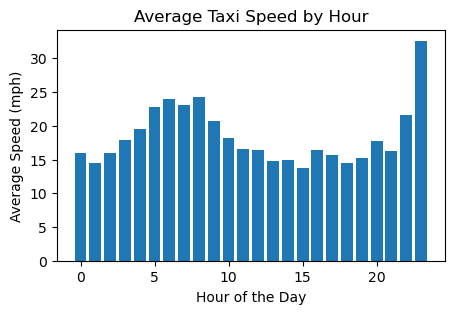

In [28]:
plt.figure(figsize=(5, 3))  # Adjusting the figure size
plt.bar(df_panda["hora"], df_panda["avg(velocidad)"])
plt.xlabel('Hour of the Day')
plt.ylabel('Average Speed (mph)')
plt.title('Average Taxi Speed by Hour')
plt.show()